## Step through of GPT2

In this workbook we show how the parts of GPT2 work.

First lets load the model

In [1]:
from transformers import GPT2LMHeadModel
model_hf = GPT2LMHeadModel.from_pretrained("gpt2") # 124M
sd_hf = model_hf.state_dict()

/Users/davidsumpter/anaconda3/envs/ContextEngineering/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Embeddings

Load in the token and position embeddings and use the to creat the input empedding.

![alt text](<figures/Embeddings.png>)


In [211]:
import tiktoken
import torch
import pandas as pd
# Input sentence
sentence = "I went for a wonderful walk in the park today and saw a"

# Tokenize the sentence
enc = tiktoken.get_encoding('gpt2')
token_ids = enc.encode(sentence)

# Decode each token to see what they are
tokens_text = [enc.decode([tid]) for tid in token_ids]
print("Tokens in the sentence:")
print(tokens_text)

# Get the token embeddings from GPT2
wte = sd_hf["transformer.wte.weight"]  # Token embeddings [vocab_size, 768]
wpe = sd_hf["transformer.wpe.weight"]  # Position embeddings [max_seq_len, 768]

print("Shape of token embeddings (wte):", wte.shape)
print("Shape of position embeddings (wpe):", wpe.shape)

# Convert token IDs to embeddings
token_embeddings = wte[token_ids]  # [seq_len, 768]
position_ids = torch.arange(len(token_ids))
position_embeddings = wpe[position_ids]  # [seq_len, 768]

# Combine token and position embeddings 
# This is the input to the embedding
input_embeddings = token_embeddings + position_embeddings  # [seq_len, 768]

# Write out the first 20 digits of the token, position and input embeddings for the first token
print("First token embeddings (first 20 dimensions):")
print(f"Token: '{tokens_text[0]}'")
print("Token embedding:", token_embeddings[0][:20])
print("Position embedding:", position_embeddings[0][:20])
print("Input embedding:", input_embeddings[0][:20])

# Output a csv where first column is token text, 
# next 20 columns are token embedding, next 20 columns are input embedding
csv_data = []
for idx, token_text in enumerate(tokens_text):
    row = [token_text]  # First column: token text
    # Next 20 columns: token embedding
    row.extend(token_embeddings[idx][:20].tolist())
    # Next 20 columns: input embedding
    row.extend(input_embeddings[idx][:20].tolist())
    csv_data.append(row)
df = pd.DataFrame(csv_data)
df.to_csv('sentence_embeddings.csv', index=False)

current_embeddings = input_embeddings

Tokens in the sentence:
['I', ' went', ' for', ' a', ' wonderful', ' walk', ' in', ' the', ' park', ' today', ' and', ' saw', ' a']
Shape of token embeddings (wte): torch.Size([50257, 768])
Shape of position embeddings (wpe): torch.Size([1024, 768])
First token embeddings (first 20 dimensions):
Token: 'I'
Token embedding: tensor([ 0.1474, -0.0959,  0.1430, -0.1062, -0.0123, -0.0959, -0.2173, -0.1137,
         0.0917,  0.0808, -0.0837,  0.1065, -0.0388,  0.1131,  0.0043, -0.1781,
         0.1281,  0.0643, -0.0113,  0.1237])
Position embedding: tensor([-0.0188, -0.1974,  0.0040,  0.0113,  0.0638, -0.1050,  0.0369, -0.1680,
        -0.0491, -0.0565, -0.0025,  0.0135, -0.0042,  0.0151,  0.0166, -0.1381,
        -0.0063, -0.0461,  0.0267, -0.2042])
Input embedding: tensor([ 0.1286, -0.2933,  0.1470, -0.0949,  0.0516, -0.2009, -0.1803, -0.2818,
         0.0426,  0.0243, -0.0862,  0.1200, -0.0430,  0.1282,  0.0209, -0.3162,
         0.1218,  0.0182,  0.0153, -0.0805])


### Sentence Matrix

This produces the sentence matrix.

![alt text](<figures/Sentence Matrix.png>)

We can also look at which words are most similar to each word.

In [212]:
# A function to find most similar tokens for each row
import torch.nn.functional as F

def find_similar_tokens(output_matrix, top_k=5):
    """
    Find the top_k most similar tokens in wte for each row of output_matrix.
    
    Args:
        output_matrix: [seq_len, 768] tensor
        top_k: number of top similar tokens to return
        apply_position_mask: if True, apply position_dimension_masks to filter dimensions
    
    Returns:
        List of lists, where each inner list contains (token_text, token_id, similarity) tuples
    """
    results = []
    for token_idx in range(len(output_matrix)):
        # Get the output for this token
        test_vector = output_matrix[token_idx]  # [768]
        
 
        test_vector_norm = F.normalize(test_vector.unsqueeze(0), dim=1)  # [1, 768]
        all_embeddings_norm = F.normalize(wte, dim=1)  # [50257, 768]
        
        # Compute cosine similarity between test vector and all token embeddings
        similarities = (all_embeddings_norm @ test_vector_norm.T).squeeze()  # [50257]

        # Get top k most similar tokens
        top_similarities, top_indices = torch.topk(similarities, top_k)
        
        token_results = []
        for sim, idx in zip(top_similarities, top_indices):
            token_text = enc.decode([idx.item()])
            token_results.append((token_text, idx.item(), sim.item()))
        
        results.append(token_results)
    
    return results
 
similar_results = find_similar_tokens(token_embeddings, top_k=5)

for token_idx, token_results in enumerate(similar_results):
    # Get just the token names from the results
    token_names = [f"'{t[0]}' (similarity {t[2]:.4f})" for t in token_results]
    tokens_str = ", ".join(token_names)
    # Get the similarity of the most similar token
    top_similarity = token_results[0][2]
    print(f"Token '{tokens_text[token_idx]}' similar to: {tokens_str}")
    
similar_results = find_similar_tokens(current_embeddings, top_k=5)

print("Now we look at how positional embeddings have changed things:")
for token_idx, token_results in enumerate(similar_results):
    # Get just the token names from the results
    token_names = [f"'{t[0]}' (similarity {t[2]:.4f})" for t in token_results]
    tokens_str = ", ".join(token_names)
    # Get the similarity of the most similar token
    top_similarity = token_results[0][2]
    print(f"Token '{tokens_text[token_idx]}' similar to: {tokens_str}")



Token 'I' similar to: 'I' (similarity 1.0000), ' I' (similarity 0.7544), 'It' (similarity 0.6682), 'My' (similarity 0.6500), 'We' (similarity 0.6416)
Token ' went' similar to: ' went' (similarity 1.0000), ' goes' (similarity 0.7674), ' took' (similarity 0.7041), ' came' (similarity 0.6955), ' became' (similarity 0.6542)
Token ' for' similar to: ' for' (similarity 1.0000), ' in' (similarity 0.7126), ' to' (similarity 0.7077), ' on' (similarity 0.6694), ' with' (similarity 0.6677)
Token ' a' similar to: ' a' (similarity 1.0000), ' an' (similarity 0.8916), ' the' (similarity 0.8385), ' in' (similarity 0.6420), ' some' (similarity 0.6372)
Token ' wonderful' similar to: ' wonderful' (similarity 1.0000), ' fantastic' (similarity 0.8301), ' lovely' (similarity 0.8254), ' fabulous' (similarity 0.7852), ' marvelous' (similarity 0.7837)
Token ' walk' similar to: ' walk' (similarity 1.0000), ' walking' (similarity 0.7196), ' walks' (similarity 0.7043), ' walked' (similarity 0.6937), ' Walk' (simi

### Prediction

Here we use the Prediction step to try to predict the next word.

![alt text](<figures/Prediction.png>)

This doesn't give good predictions at this stage because we haven't done any attention or transform.

In [206]:

# And a function to find predicted words using the model head
def predict_next_word(layer_input, top_k=10):
    """
    Predict the next word given the current layer input.
    
    Args:
        layer_input: [seq_len, 768] tensor
        top_k: number of top predictions to return
    
    Returns:
        top_probs: [top_k] tensor of probabilities
        top_indices: [top_k] tensor of token indices
    """
    # Get weights from global scope
    ln_f_weight = sd_hf["transformer.ln_f.weight"]
    ln_f_bias = sd_hf["transformer.ln_f.bias"]
    lm_head_weight = sd_hf["lm_head.weight"]
    
    # Apply final layer normalization
    current_output = F.layer_norm(layer_input, (d_model,), ln_f_weight, ln_f_bias)
    
    # Apply the language model head (projects to vocabulary)
    logits = current_output @ lm_head_weight.T  # [seq_len, vocab_size]
    last_token_logits = logits[-1]  # [vocab_size]
    
    # Get top k predictions
    top_probs, top_indices = torch.topk(F.softmax(last_token_logits, dim=-1), top_k)
    
    prob_string = ""  # Initialize prob_string
    for i, (prob, idx) in enumerate(zip(top_probs, top_indices)):
        token_text = enc.decode([idx.item()])
        prob_string += f"  {i+1}. '{token_text}' (probability: {prob.item():.4f})\n"
    print(prob_string)

    return top_probs, top_indices

# Look at prediction of embeddings alone.
print("Predicting next token based on embeddings alone:")
print("="*80)
# Adjust input embeddings

# Predict next word using only the input embeddings (token + position)
# This shows what the model would predict if it skipped all transformer layers
top_probs_embed, top_indices_embed = predict_next_word(current_embeddings, top_k=10)
print("="*80)

Predicting next token based on embeddings alone:
  1. ' mathemat' (probability: 0.4491)
  2. ' destro' (probability: 0.3220)
  3. ' challeng' (probability: 0.1851)
  4. ' arrang' (probability: 0.0291)
  5. ' conclud' (probability: 0.0047)
  6. ' corrid' (probability: 0.0046)
  7. ' cryst' (probability: 0.0014)
  8. 'theless' (probability: 0.0013)
  9. ' Citiz' (probability: 0.0009)
  10. ' exha' (probability: 0.0003)



### Attention

Lets have a look at the attention relationships for the first layer of GPT2. There are 12 of these attention layers on total. Each layer has 12 attention heads.

![alt text](<figures/Attention.png>)

Here we show four of the attention heads for four different sentences. I recommend looking at different heads with different sentences and exploring what happens.

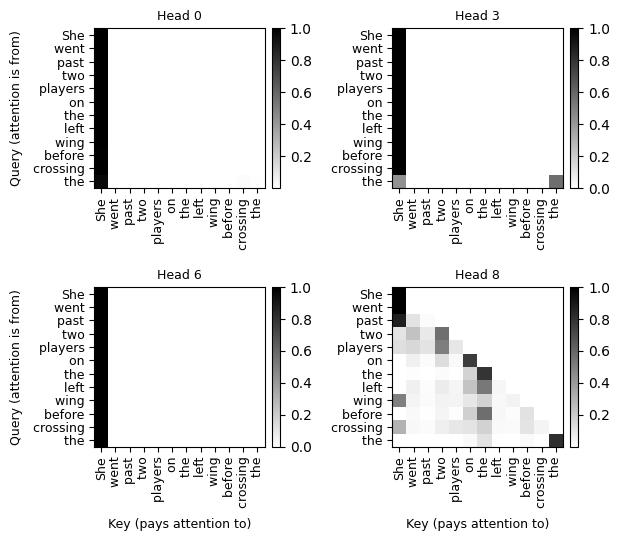

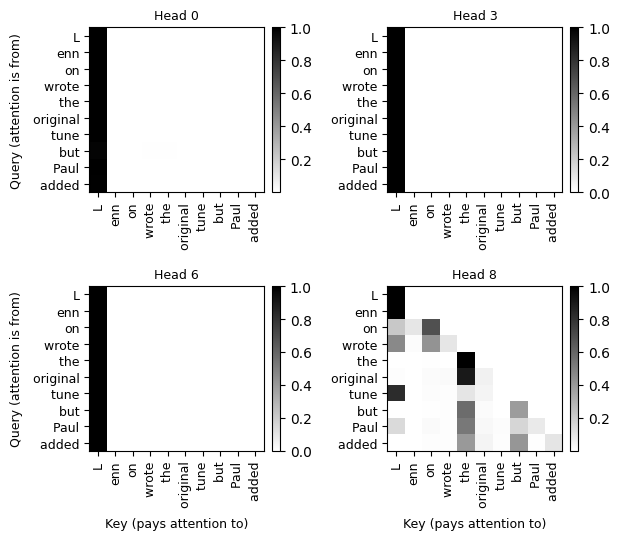

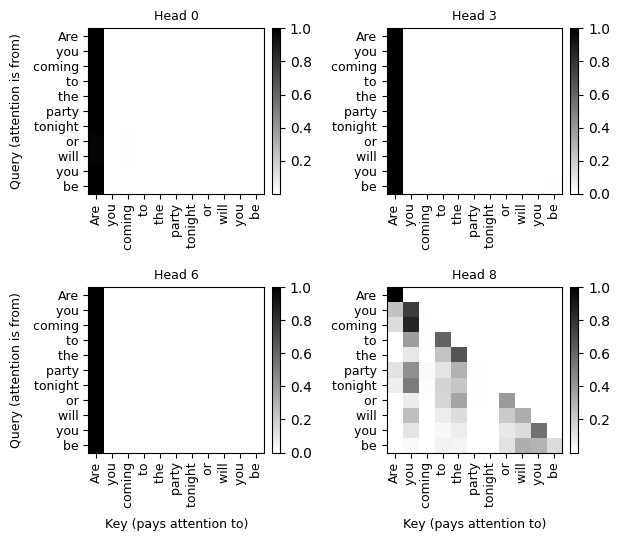

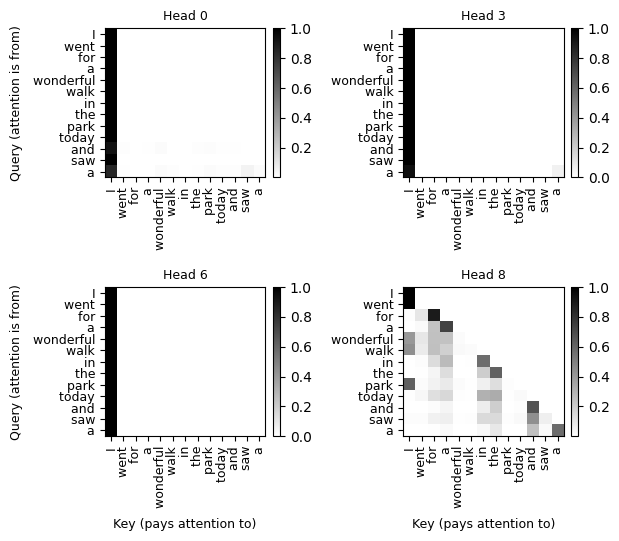

Comparison of Attention Weights for Head 8 Across Different Sentences


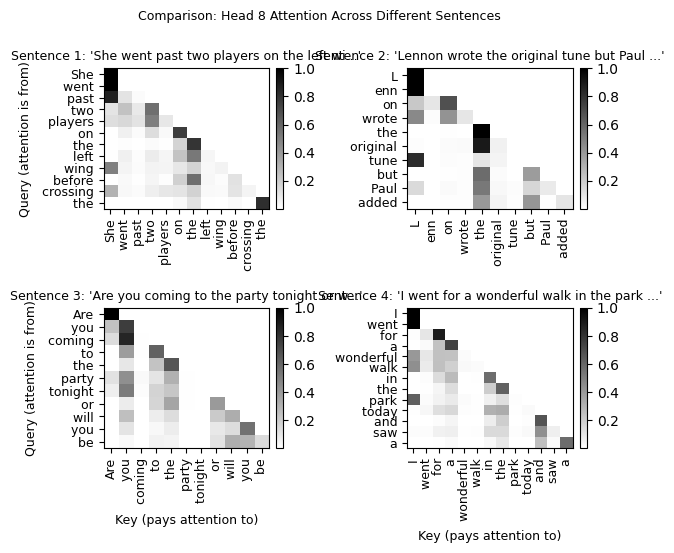

In [215]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

sentences = ["She went past two players on the left wing before crossing the",
             "Lennon wrote the original tune but Paul added",
             "Are you coming to the party tonight or will you be",
             "I went for a wonderful walk in the park today and saw a",]

heads_to_show = [0, 3, 6, 8]  # Heads to visualize

# Store attention data for comparison plot
sentence_attention_data = []

for sentence in sentences:
    token_ids = enc.encode(sentence)
    tokens_text = [enc.decode([tid]) for tid in token_ids]
    position_ids = torch.arange(len(token_ids))
    token_embeddings = wte[token_ids]  # [seq_len, 768]
    position_ids = torch.arange(len(token_ids))
    position_embeddings = wpe[position_ids]  # [seq_len, 768]
    input_embeddings = token_embeddings + position_embeddings  # [seq_len, 768]

    # Define model parameters and extract weights for a specific layer
    layer_num = 0  # We'll analyze layer 0

    # GPT2 model dimensions
    d_model = 768  # Hidden dimension
    n_heads = 12   # Number of attention heads
    head_dim = d_model // n_heads  # Dimension per head = 64

    # Extract Q, K, V weights and biases for the specified layer
    # GPT2 stores Q, K, V together in a single weight matrix
    qkv_weight = sd_hf[f"transformer.h.{layer_num}.attn.c_attn.weight"]  # [768, 2304]
    qkv_bias = sd_hf[f"transformer.h.{layer_num}.attn.c_attn.bias"]  # [2304]

    # Split the combined QKV weights into separate Q, K, V matrices
    # Each has shape [768, 768] for weights and [768] for biases
    q_weight, k_weight, v_weight = qkv_weight.split(d_model, dim=1)
    q_bias, k_bias, v_bias = qkv_bias.split(d_model)

    # Create mask to only look at past and present tokens
    seq_len = len(tokens_text)
    causal_mask = torch.tril(torch.ones(seq_len, seq_len))  # Lower triangular = 1, upper = 0
    causal_mask = torch.where(causal_mask == 0, float('-inf'), 0.0)

    # Create a 2x2 subplot grid for 4 heads
    # Show heads 0, 3, 6, 9 (a sample across the 12 heads)
    fig, axes = plt.subplots(2, 2, figsize=(6.30, 5.51))
    axes = axes.flatten()
    
    # Store data for the last head for comparison plot
    last_head_idx = heads_to_show[-1]
    
    # Loop over selected heads
    for plot_idx, head_idx in enumerate(heads_to_show):
        # Extract weights for this head
        start_idx = head_idx * head_dim
        end_idx = start_idx + head_dim
        
        q_head_i = q_weight[:, start_idx:end_idx]  # [768, 64]
        k_head_i = k_weight[:, start_idx:end_idx]  # [768, 64]
        
        q_bias_head_i = q_bias[start_idx:end_idx]  # [64]
        k_bias_head_i = k_bias[start_idx:end_idx]  # [64]
        
        # Apply Q, K projections to the input embeddings
        Q_i = input_embeddings @ q_head_i + q_bias_head_i  # [seq_len, 64]
        K_i = input_embeddings @ k_head_i + k_bias_head_i  # [seq_len, 64]
        
        # Compute attention scores: Q @ K^T
        attention_scores_i = Q_i @ K_i.T  # [seq_len, seq_len]
        
        # Scale by sqrt(head_dim)
        scaled_attention_scores_i = attention_scores_i / (head_dim ** 0.5)
        
        # Add causal mask BEFORE softmax (prevents attending to future tokens)
        scaled_attention_scores_i = scaled_attention_scores_i + causal_mask
        
        # Apply softmax to get attention weights
        attention_weights_scaled = F.softmax(scaled_attention_scores_i, dim=-1)
        
        # Create a masked array where masked positions will be shown as white
        attention_array = attention_weights_scaled.detach().numpy()
        # Create mask for upper triangle (future positions)
        mask = np.triu(np.ones_like(attention_array), k=1).astype(bool)
        masked_attention = np.ma.array(attention_array, mask=mask)
        
        # Visualize in the corresponding subplot with linear color scale
        ax = axes[plot_idx]
        im = ax.imshow(masked_attention, cmap='gray_r', aspect='auto')
        im.cmap.set_bad(color="white")  # Set masked values to very light green
        ax.set_title(f'Head {head_idx}', fontsize=9)
        
        # Determine subplot position (2x2 grid)
        row = plot_idx // 2
        col = plot_idx % 2
        
        # Only add xlabel if NOT in top row
        if row != 0:
            ax.set_xlabel('Key (pays attention to)', fontsize=9)
        
        # Only add ylabel if NOT in right column
        if col != 1:
            ax.set_ylabel('Query (attention is from)', fontsize=9)
        
        # Add token labels to both axes
        ax.set_xticks(range(len(tokens_text)))
        ax.set_xticklabels(tokens_text, rotation=90, fontsize=9)
        ax.set_yticks(range(len(tokens_text)))
        ax.set_yticklabels(tokens_text, fontsize=9)
        
        # Add colorbar for each subplot
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        
        # Store data for the last head for comparison plot
        if head_idx == last_head_idx:
            sentence_attention_data.append({
                'sentence': sentence,
                'tokens_text': tokens_text,
                'masked_attention': masked_attention,
                'head_idx': head_idx
            })

    plt.tight_layout()
    plt.show()



# Create comparison plot for the last head across all sentences
print("Comparison of Attention Weights for Head", sentence_attention_data[0]['head_idx'], "Across Different Sentences")
fig, axes = plt.subplots(2, 2, figsize=(6.30, 5.51))
axes = axes.flatten()

for plot_idx, data in enumerate(sentence_attention_data):
    ax = axes[plot_idx]
    im = ax.imshow(data['masked_attention'], cmap='gray_r', aspect='auto')
    im.cmap.set_bad(color="white")
    
    ax.set_title(f"Sentence {plot_idx + 1}: '{data['sentence'][:40]}...'", fontsize=9)
    
    # Determine subplot position (2x2 grid)
    row = plot_idx // 2
    col = plot_idx % 2
    
    # Only add xlabel if NOT in top row
    if row != 0:
        ax.set_xlabel('Key (pays attention to)', fontsize=9)
    
    # Only add ylabel if NOT in right column
    if col != 1:
        ax.set_ylabel('Query (attention is from)', fontsize=9)
    
    # Add token labels to both axes
    tokens = data['tokens_text']
    ax.set_xticks(range(len(tokens)))
    ax.set_xticklabels(tokens, rotation=90, fontsize=9)
    ax.set_yticks(range(len(tokens)))
    ax.set_yticklabels(tokens, fontsize=9)
    
    # Add colorbar for each subplot
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.suptitle(f'Comparison: Head {sentence_attention_data[0]["head_idx"]} Attention Across Different Sentences', fontsize=9, y=0.995)
plt.tight_layout()
plt.show()


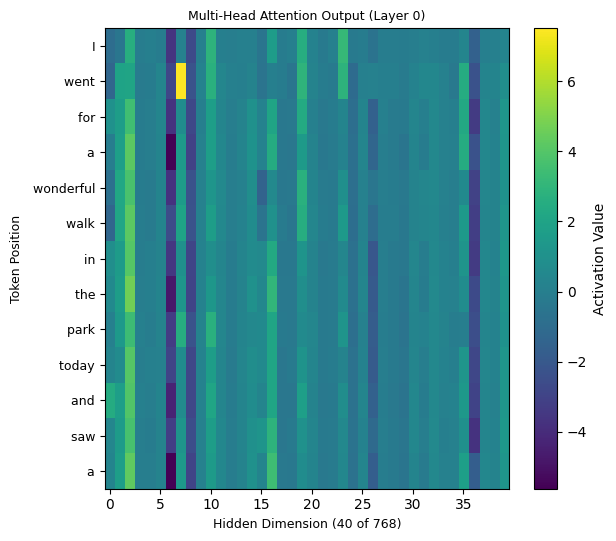

Finding tokens that approximate the attention output vectors...
Token 'I' adjusted by a token similar to: make, OX,  tiny, My,  tomato (most similar 0.1464)
Token ' went' adjusted by a token similar to:  oun,  little,  wind,  word,  quiet (most similar 0.0482)
Token ' for' adjusted by a token similar to:  tiny,  small,  slight,  perfect, ramid (most similar 0.0740)
Token ' a' adjusted by a token similar to:  tiny,  slight, ramid,  small,  perfect (most similar 0.0893)
Token ' wonderful' adjusted by a token similar to:  little,  slight,  tiny,  small,  the (most similar 0.0678)
Token ' walk' adjusted by a token similar to:  little,  tiny,  slight,  small,  the (most similar 0.0636)
Token ' in' adjusted by a token similar to:  tiny,  slight,  small, mercial,  perfect (most similar 0.0800)
Token ' the' adjusted by a token similar to:  tiny,  slight,  small,  perfect, mercial (most similar 0.0872)
Token ' park' adjusted by a token similar to:  whistle, mercial,  scoreboard,  slight,  oun (

In [217]:
# Compute the multi-head attention output with output projection

# Step 1: Multi-Head Attention - compute outputs from all 12 heads with causal masking
head_outputs = []

for head_idx in range(n_heads):
    # Extract weights for this head
    start_idx = head_idx * head_dim
    end_idx = start_idx + head_dim
    q_head_i = q_weight[:, start_idx:end_idx]  # [768, 64]
    k_head_i = k_weight[:, start_idx:end_idx]  # [768, 64]
    v_head_i = v_weight[:, start_idx:end_idx]  # [768, 64]
    q_bias_head_i = q_bias[start_idx:end_idx]  # [64]
    k_bias_head_i = k_bias[start_idx:end_idx]  # [64]
    v_bias_head_i = v_bias[start_idx:end_idx]  # [64]
    
    # Apply Q, K, V projections
    Q_i = input_embeddings @ q_head_i + q_bias_head_i  # [seq_len, 64]
    K_i = input_embeddings @ k_head_i + k_bias_head_i  # [seq_len, 64]
    V_i = input_embeddings @ v_head_i + v_bias_head_i  # [seq_len, 64]
    
    # Compute attention with causal masking
    attention_scores_i = Q_i @ K_i.T / (head_dim ** 0.5)  # [seq_len, seq_len]
    attention_scores_i = attention_scores_i + causal_mask  # Add causal mask
    attention_weights_i = F.softmax(attention_scores_i, dim=-1)  # [seq_len, seq_len]
    head_output_i = attention_weights_i @ V_i  # [seq_len, 64]
    
    head_outputs.append(head_output_i)

# Step 2: Concatenate all head outputs
multi_head_output = torch.cat(head_outputs, dim=-1)  # [seq_len, 768]

# Step 3: Apply output projection
c_proj_weight = sd_hf[f"transformer.h.{layer_num}.attn.c_proj.weight"]  # [768, 768]
c_proj_bias = sd_hf[f"transformer.h.{layer_num}.attn.c_proj.bias"]  # [768]

attn_output = multi_head_output @ c_proj_weight + c_proj_bias  # [seq_len, 768]

# Visualize the attention output as a heatmap
# For the first 40 dimensions across all tokens
plt.figure(figsize=(6.30, 5.51))
plt.imshow(attn_output[:, :40].detach().numpy(), cmap='viridis', aspect='auto')
plt.colorbar(label='Activation Value')
plt.title(f'Multi-Head Attention Output (Layer {layer_num})', fontsize=9)
plt.xlabel('Hidden Dimension (40 of 768)', fontsize=9)
plt.ylabel('Token Position', fontsize=9)

# Add token labels to y-axis
plt.yticks(range(len(tokens_text)), tokens_text, fontsize=9)

plt.tight_layout()
plt.show()

current_embedding = attn_output  - position_embeddings 

# Find the nearest tokens to each attention output vector
print("Finding tokens that approximate the attention output vectors...")
similar_results = find_similar_tokens(current_embedding, top_k=5)

for token_idx, token_results in enumerate(similar_results):
    # Get just the token names from the results
    token_names = [t[0] for t in token_results]
    tokens_str = ", ".join(token_names)
    print(f"Token '{tokens_text[token_idx]}' adjusted by a token similar to: {tokens_str} (most similar {token_results[0][2]:.4f})")


### Transform

Now its time to put it through a multi-level perceptron...

![alt text](<figures/Transform.png>)


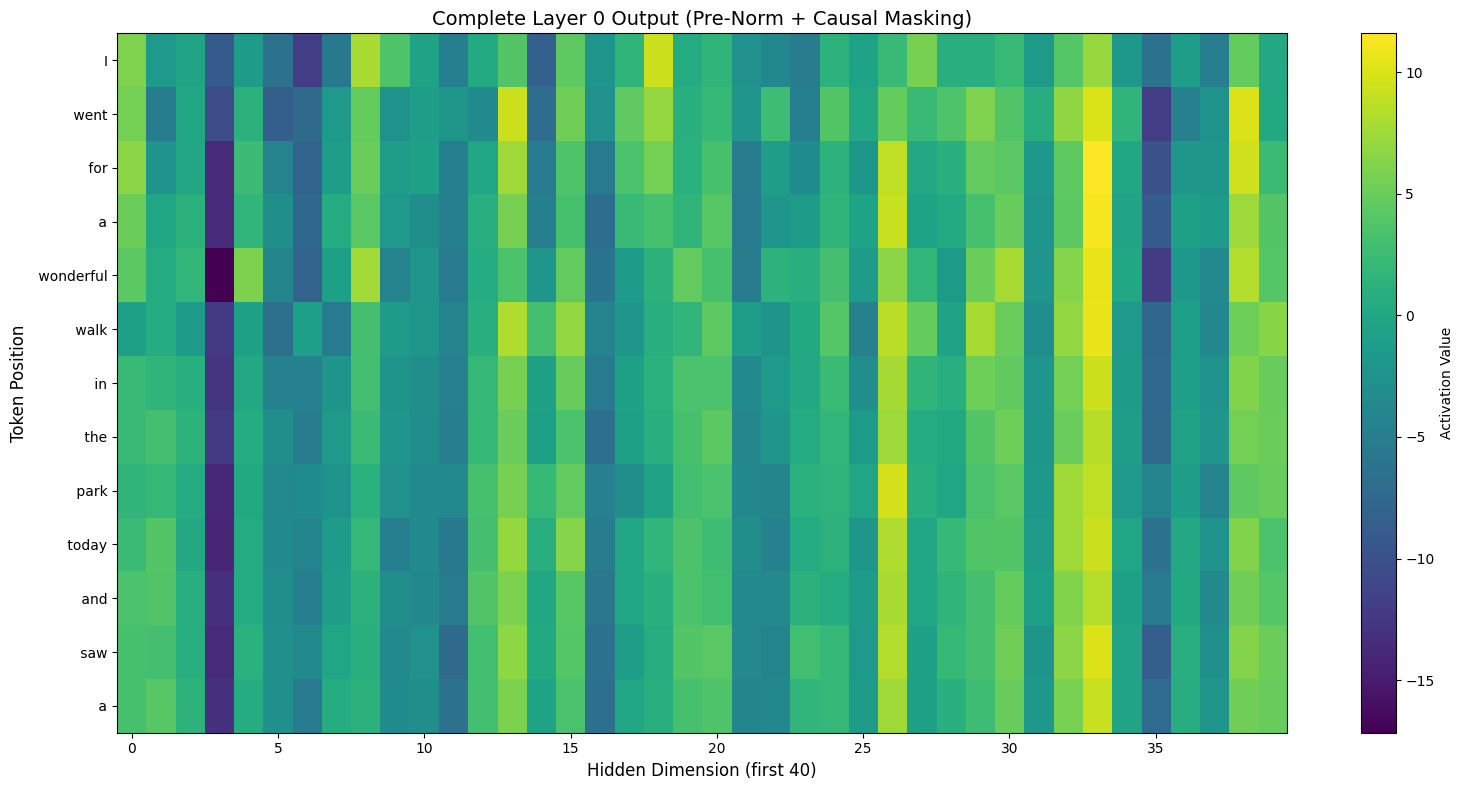

Finding tokens that approximate the attention output vectors...
Token 'I' adjusted by a token similar to:  instruments, ouf, ves,  sten, pee (most similar 0.0984)
Token ' went' adjusted by a token similar to:  blue, ets,  note,  went,  goes (most similar 0.1084)
Token ' for' adjusted by a token similar to:  for, ., ,,  from,  in (most similar 0.1426)
Token ' a' adjusted by a token similar to:  for, ,, .,  from,  and (most similar 0.1693)
Token ' wonderful' adjusted by a token similar to:  for, ,, .,  from,  and (most similar 0.1553)
Token ' walk' adjusted by a token similar to:  for, ,,  from, .,  and (most similar 0.1402)
Token ' in' adjusted by a token similar to:  for, ,, .,  and,  from (most similar 0.1593)
Token ' the' adjusted by a token similar to:  for, ,,  and, .,  in (most similar 0.1681)
Token ' park' adjusted by a token similar to:  for, ,, .,  and,  in (most similar 0.1496)
Token ' today' adjusted by a token similar to:  for, ,, .,  and,  in (most similar 0.1486)
Token ' a

In [ ]:
# Complete the transformer layer with LayerNorm (pre-norm), MLP, and residuals

# Get all layer weights
ln1_weight = sd_hf[f"transformer.h.{layer_num}.ln_1.weight"]  # [768]
ln1_bias = sd_hf[f"transformer.h.{layer_num}.ln_1.bias"]  # [768]
ln2_weight = sd_hf[f"transformer.h.{layer_num}.ln_2.weight"]  # [768]
ln2_bias = sd_hf[f"transformer.h.{layer_num}.ln_2.bias"]  # [768]

mlp_c_fc_weight = sd_hf[f"transformer.h.{layer_num}.mlp.c_fc.weight"]  # [768, 3072]
mlp_c_fc_bias = sd_hf[f"transformer.h.{layer_num}.mlp.c_fc.bias"]  # [3072]
mlp_c_proj_weight = sd_hf[f"transformer.h.{layer_num}.mlp.c_proj.weight"]  # [3072, 768]
mlp_c_proj_bias = sd_hf[f"transformer.h.{layer_num}.mlp.c_proj.bias"]  # [768]

# ATTENTION BLOCK (we already computed attn_output above)
# Let's recompute the attention with pre-norm:

# Step 1: Apply LayerNorm before attention (pre-norm architecture)
ln1_output = F.layer_norm(input_embeddings, (d_model,), ln1_weight, ln1_bias)

# Recompute multi-head attention with pre-norm input
head_outputs_prenorm = []
for head_idx in range(n_heads):
    start_idx = head_idx * head_dim
    end_idx = start_idx + head_dim
    
    q_head_i = q_weight[:, start_idx:end_idx]
    k_head_i = k_weight[:, start_idx:end_idx]
    v_head_i = v_weight[:, start_idx:end_idx]
    
    q_bias_head_i = q_bias[start_idx:end_idx]
    k_bias_head_i = k_bias[start_idx:end_idx]
    v_bias_head_i = v_bias[start_idx:end_idx]
    
    Q_i = ln1_output @ q_head_i + q_bias_head_i
    K_i = ln1_output @ k_head_i + k_bias_head_i
    V_i = ln1_output @ v_head_i + v_bias_head_i
    
    attention_scores_i = Q_i @ K_i.T / (head_dim ** 0.5)
    attention_scores_i = attention_scores_i + causal_mask
    attention_weights_i = F.softmax(attention_scores_i, dim=-1)
    head_output_i = attention_weights_i @ V_i
    
    head_outputs_prenorm.append(head_output_i)

multi_head_output_prenorm = torch.cat(head_outputs_prenorm, dim=-1)
attn_output_prenorm = multi_head_output_prenorm @ c_proj_weight + c_proj_bias

# Step 2: First residual connection
residual_after_attn = input_embeddings + attn_output_prenorm

# Step 3: Apply LayerNorm BEFORE MLP (pre-norm architecture)
ln2_output = F.layer_norm(residual_after_attn, (d_model,), ln2_weight, ln2_bias)

# Step 4: Apply MLP
mlp_hidden = ln2_output @ mlp_c_fc_weight + mlp_c_fc_bias
mlp_hidden = F.gelu(mlp_hidden)
mlp_output = mlp_hidden @ mlp_c_proj_weight + mlp_c_proj_bias

# Step 5: Second residual connection
layer_output = residual_after_attn + mlp_output
current_embeddings = mlp_output - position_embeddings

# Visualize the final layer output
plt.figure(figsize=(6.30, 5.51))
plt.imshow(current_embeddings[:, :40].detach().numpy(), cmap='viridis', aspect='auto')
plt.colorbar(label='Activation Value')
plt.title(f'Complete Layer {layer_num} Output (Pre-Norm + Causal Masking)', fontsize=9)
plt.xlabel('Hidden Dimension (first 40)', fontsize=9)
plt.ylabel('Token Position', fontsize=9)

# Add token labels to y-axis
plt.yticks(range(len(tokens_text)), tokens_text, fontsize=9)

plt.tight_layout()
plt.show()

# Find the nearest tokens to each attention output vector
print("Finding tokens that approximate the attention output vectors...")
similar_results = find_similar_tokens(current_embeddings, top_k=5)

for token_idx, token_results in enumerate(similar_results):
    # Get just the token names from the results
    token_names = [t[0] for t in token_results]
    tokens_str = ", ".join(token_names)
    print(f"Token '{tokens_text[token_idx]}' adjusted by a token similar to: '{tokens_str}' (most similar {token_results[0][2]:.4f})")


In [223]:
# Process all 12 transformer layers
# Initialize with input embeddings
current_layer_input = input_embeddings  # [seq_len, 768]

for layer_idx in range(12):
    # Get layer weights
    qkv_weight = sd_hf[f"transformer.h.{layer_idx}.attn.c_attn.weight"]
    qkv_bias = sd_hf[f"transformer.h.{layer_idx}.attn.c_attn.bias"]
    c_proj_weight = sd_hf[f"transformer.h.{layer_idx}.attn.c_proj.weight"]
    c_proj_bias = sd_hf[f"transformer.h.{layer_idx}.attn.c_proj.bias"]
    
    ln1_weight = sd_hf[f"transformer.h.{layer_idx}.ln_1.weight"]
    ln1_bias = sd_hf[f"transformer.h.{layer_idx}.ln_1.bias"]
    
    ln2_weight = sd_hf[f"transformer.h.{layer_idx}.ln_2.weight"]
    ln2_bias = sd_hf[f"transformer.h.{layer_idx}.ln_2.bias"]
    
    mlp_c_fc_weight = sd_hf[f"transformer.h.{layer_idx}.mlp.c_fc.weight"]
    mlp_c_fc_bias = sd_hf[f"transformer.h.{layer_idx}.mlp.c_fc.bias"]
    mlp_c_proj_weight = sd_hf[f"transformer.h.{layer_idx}.mlp.c_proj.weight"]
    mlp_c_proj_bias = sd_hf[f"transformer.h.{layer_idx}.mlp.c_proj.bias"]
    
    # Split QKV weights
    q_weight, k_weight, v_weight = qkv_weight.split(d_model, dim=1)
    q_bias, k_bias, v_bias = qkv_bias.split(d_model)
    
    # ATTENTION BLOCK
    # Apply LayerNorm BEFORE attention (pre-norm)
    ln1_output = F.layer_norm(current_layer_input, (d_model,), ln1_weight, ln1_bias)
    
    # Multi-head attention with causal masking
    head_outputs = []
    for head_idx in range(n_heads):
        start_idx = head_idx * head_dim
        end_idx = start_idx + head_dim
        
        q_head_i = q_weight[:, start_idx:end_idx]
        k_head_i = k_weight[:, start_idx:end_idx]
        v_head_i = v_weight[:, start_idx:end_idx]
        
        q_bias_head_i = q_bias[start_idx:end_idx]
        k_bias_head_i = k_bias[start_idx:end_idx]
        v_bias_head_i = v_bias[start_idx:end_idx]
        
        Q_i = ln1_output @ q_head_i + q_bias_head_i
        K_i = ln1_output @ k_head_i + k_bias_head_i
        V_i = ln1_output @ v_head_i + v_bias_head_i
        
        # Compute attention scores with causal mask
        attention_scores_i = Q_i @ K_i.T / (head_dim ** 0.5)
        attention_scores_i = attention_scores_i + causal_mask  # Add causal mask
        attention_weights_i = F.softmax(attention_scores_i, dim=-1)
        head_output_i = attention_weights_i @ V_i
        
        head_outputs.append(head_output_i)
    
    # Concatenate and project
    multi_head_output = torch.cat(head_outputs, dim=-1)
    attn_output = multi_head_output @ c_proj_weight + c_proj_bias
    
    # First residual connection
    current_layer_input = current_layer_input + attn_output

    # Remove position embeddings for similarity analysis
    layer_output_without_position = attn_output - position_embeddings

    print(f"\nTop 10 predictions before transform at layer {layer_idx}:\n")
    top_probs, top_indices = predict_next_word(current_layer_input, top_k=10)

    # MLP BLOCK
    # Apply LayerNorm BEFORE MLP (pre-norm)
    ln2_output = F.layer_norm(current_layer_input, (d_model,), ln2_weight, ln2_bias)
    
    # MLP
    mlp_hidden = ln2_output @ mlp_c_fc_weight + mlp_c_fc_bias
    mlp_hidden = F.gelu(mlp_hidden)
    mlp_output = mlp_hidden @ mlp_c_proj_weight + mlp_c_proj_bias
    
    # Second residual connection
    current_layer_input = current_layer_input + mlp_output
    
    # Remove position embeddings for similarity analysis
    layer_output_without_position = mlp_output - position_embeddings


    print(f"\nTop 10 predictions after transform at layer {layer_idx}:\n")
    top_probs, top_indices = predict_next_word(current_layer_input, top_k=10)



Top 10 predictions before transform at layer 0:

  1. ' a' (probability: 0.0308)
  2. ' great' (probability: 0.0294)
  3. ' clear' (probability: 0.0254)
  4. ' few' (probability: 0.0204)
  5. ' quick' (probability: 0.0143)
  6. ' little' (probability: 0.0136)
  7. ' fall' (probability: 0.0131)
  8. ' steady' (probability: 0.0131)
  9. ' hole' (probability: 0.0127)
  10. ' one' (probability: 0.0123)


Top 10 predictions after transform at layer 0:

  1. ' few' (probability: 0.1743)
  2. ' very' (probability: 0.0828)
  3. ' new' (probability: 0.0467)
  4. ' lot' (probability: 0.0453)
  5. ' huge' (probability: 0.0436)
  6. ' little' (probability: 0.0356)
  7. ' small' (probability: 0.0317)
  8. ' great' (probability: 0.0312)
  9. ' couple' (probability: 0.0203)
  10. ' large' (probability: 0.0168)


Top 10 predictions before transform at layer 1:

  1. ' few' (probability: 0.1380)
  2. ' lot' (probability: 0.0780)
  3. ' huge' (probability: 0.0695)
  4. ' very' (probability: 0.0680)
  5

In [222]:
# Validate our implementation against HuggingFace's official implementation
print("="*80)
print("VALIDATION: Comparing our implementation with HuggingFace GPT2")
print("="*80)

# Use HuggingFace model to get predictions
with torch.no_grad():
    # Convert token_ids to tensor and add batch dimension
    input_ids = torch.tensor([token_ids])  # [1, seq_len]
    
    # Get model outputs
    outputs = model_hf(input_ids)
    official_logits = outputs.logits[0, -1, :]  # Get last token logits [vocab_size]
    
    # Get top 10 from official model
    official_top_probs, official_top_indices = torch.topk(F.softmax(official_logits, dim=-1), 10)
    
    print("\nHuggingFace Official Model - Top 10 predictions:")
    for i, (prob, idx) in enumerate(zip(official_top_probs, official_top_indices)):
        token_text = enc.decode([idx.item()])
        print(f"  {i+1}. '{token_text}' (probability: {prob.item():.4f})")
    
    print(f"\n{'='*80}")
    print("Our Implementation - Top 10 predictions:")
    for i, (prob, idx) in enumerate(zip(top_probs, top_indices)):
        token_text = enc.decode([idx.item()])
        print(f"  {i+1}. '{token_text}' (probability: {prob.item():.4f})")
    
    print(f"\n{'='*80}")
    # Check if logits match
    logits_diff = torch.abs(official_logits - last_token_logits).max()
    print(f"\nMaximum difference in logits: {logits_diff.item():.6f}")
    
    if logits_diff < 1e-4:
        print("✓ Our implementation matches HuggingFace! The implementations are equivalent.")
    else:
        print("✗ There are differences between our implementation and HuggingFace.")
        print("   This could be due to numerical precision or implementation details.")
        
    # Check top prediction
    if official_top_indices[0] == top_indices[0]:
        print(f"✓ Top prediction matches: '{enc.decode([top_indices[0].item()])}'")
    else:
        print(f"✗ Top predictions differ:")
        print(f"   Official: '{enc.decode([official_top_indices[0].item()])}'")
        print(f"   Ours: '{enc.decode([top_indices[0].item()])}'")
    
    # Check if top-5 predictions match
    top5_match = sum([1 for i in range(5) if top_indices[i] == official_top_indices[i]])
    print(f"\nTop-5 predictions that match: {top5_match}/5")

print("="*80)

VALIDATION: Comparing our implementation with HuggingFace GPT2

HuggingFace Official Model - Top 10 predictions:
  1. ' lot' (probability: 0.0739)
  2. ' beautiful' (probability: 0.0702)
  3. ' great' (probability: 0.0524)
  4. ' couple' (probability: 0.0380)
  5. ' bunch' (probability: 0.0326)
  6. ' few' (probability: 0.0311)
  7. ' huge' (probability: 0.0275)
  8. ' nice' (probability: 0.0188)
  9. ' very' (probability: 0.0182)
  10. ' lovely' (probability: 0.0158)

Our Implementation - Top 10 predictions:
  1. ' lot' (probability: 0.0741)
  2. ' beautiful' (probability: 0.0700)
  3. ' great' (probability: 0.0524)
  4. ' couple' (probability: 0.0380)
  5. ' bunch' (probability: 0.0327)
  6. ' few' (probability: 0.0311)
  7. ' huge' (probability: 0.0275)
  8. ' nice' (probability: 0.0188)
  9. ' very' (probability: 0.0182)
  10. ' lovely' (probability: 0.0158)


Maximum difference in logits: 28.608734
✗ There are differences between our implementation and HuggingFace.
   This could b